In [25]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import utils.remove_cols as remove_cols
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier

In [2]:
class LogisticClassification:

    def __init__(self, lr=0.001, n_iters=1000):
        self.lr = lr
        self.n_iters = n_iters
        self.n_samples = None
        self.n_features = None
        self.weights = None
        self.bias = None
        self.cost_hist = []


    def fit(self, X, y):
        self.n_samples, self.n_features = X.shape
        self.weights = np.zeros(self.n_features)[:, np.newaxis]
        self.bias = 0
        for _ in range(self.n_iters):
            y_pred = self.sigmoid(X @ self.weights + self.bias)
            derivative_loss = self.derivative_loss(y, y_pred)
            dw, db = self.gradient(X, y_pred, derivative_loss)
            self.update_params(dw, db)
            self.cost_hist.append(self.cost(y, y_pred))
    

    def gradient(self, X, y_pred, derivative_loss):
        derivative_weights = X.T @ (derivative_loss * y_pred * (1 - y_pred)) / self.n_samples
        derivative_bias = np.mean(derivative_loss * y_pred * (1 - y_pred)) / self.n_samples
        return derivative_weights, derivative_bias


    def cost(self, y, y_pred):
        return -(1 / self.n_samples) * np.sum(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))


    def derivative_loss(self, y, y_pred):
        return -y / y_pred + (1 - y)/(1 - y_pred)


    def update_params(self, dw, db):
        self.weights -= self.lr * dw
        self.bias -= self.lr * db


    def predict(self, X):
        y_pred = self.sigmoid(X @ self.weights + self.bias)
        return np.array([1 if i > 0.5 else 0 for i in y_pred])


    def predict_proba(self, X):
        y_pred = X @ self.weights + self.bias
        return y_pred

    
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    

\begin{align}
\hat{y} & = \sigma(Xw + b) \\ \\
\ L(\hat{y}, y) & =  -y * \ln({\hat{y}}) + (1-y) * \ln({1 - \hat{y}}) \\ \\
\ C(\theta) & = \frac{1}{N} * \sum_{i=1}^N L \left( \hat{y} (x^{(i)}, \theta), y^{(i)} \right) \\ \\
\ \nabla C & = (\frac{\partial C}{\partial w}, \frac{\partial C}{\partial b})^T \\ \\
\frac{\partial C}{\partial w} & = X^T \left(\frac{\partial C}{\partial L} * \hat{y} * (1 - \hat{y}) \right) * \frac{1}{N} \\ \\
\frac{\partial C}{\partial b} & = \frac{1}{N} * \sum_{\hat{y}} \left(\frac{\partial C}{\partial L} * \hat{y} * (1 - \hat{y}) \right)
\end{align}

# IMPORTIEREN

In [3]:
df = pd.read_csv("immoscout_cleaned_lat_lon_fixed_v7.csv")

/tmp/ipykernel_80110/2143901549.py:1: DtypeWarning: Columns (33) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("immoscout_cleaned_lat_lon_fixed_v7.csv")


# BEREINIGEN / IMPUTIEREN

# TRANSFORMIEREN

In [4]:
# create dictionary with object-type information
types_nrs = dict(enumerate(df["type"].unique()))
types_name = {v: k for k, v in types_nrs.items()}
print(types_nrs, types_name)
# change object-type to numeric value
df["type"] = df["type"].map(types_name)

# keep only cols with type int or float
df = df.select_dtypes(include=["int64", "float64"])
# remove specific columns
df_remove = pd.read_excel("fixtures/remove_cols.xlsx")
df_remove = remove_cols.remove_chars_space(df_remove, "feature")
dct = remove_cols.get_dct_from_df(df_remove)
assert len(dct) == len(df.columns)
df = df[[k for k, v in dct.items() if v == 1]]

# test
assert len(df.columns) == 30
assert df.values.shape[0] != 0

{0: 'penthouse', 1: 'terrace-house', 2: 'detached-house', 3: 'flat', 4: 'stepped-house', 5: 'farmhouse', 6: 'semi-detached-house', 7: 'stepped-apartment', 8: 'duplex-maisonette', 9: 'attic-flat', 10: 'loft', 11: 'chalet', 12: 'villa', 13: 'attic-room', 14: 'secondary-suite', 15: 'castle', 16: 'detached-secondary-suite', 17: 'studio', 18: 'furnished-residential-property', 19: 'rustico', 20: 'single-room'} {'penthouse': 0, 'terrace-house': 1, 'detached-house': 2, 'flat': 3, 'stepped-house': 4, 'farmhouse': 5, 'semi-detached-house': 6, 'stepped-apartment': 7, 'duplex-maisonette': 8, 'attic-flat': 9, 'loft': 10, 'chalet': 11, 'villa': 12, 'attic-room': 13, 'secondary-suite': 14, 'castle': 15, 'detached-secondary-suite': 16, 'studio': 17, 'furnished-residential-property': 18, 'rustico': 19, 'single-room': 20}


# MODEL (PREPARE DATA)

In [5]:
# drop nan because the model can't handle them
df = df.dropna() # 1016 / 13378 = 7.6% of data is lost
# make Matrix y as target with column type
y = df["type"].values[:, np.newaxis]
# make Matrix X as features with all columns except type
X = df.drop(["type"], axis=1).values
assert type(y) == np.ndarray
assert type(X) == np.ndarray
# standardize X
X = (X - X.mean(axis=0)) / X.std(axis=0)
# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# MODEL (PREPARE MODEL)

In [6]:
# create 20 models and store them in a list
models = [LogisticClassification(lr=0.01, n_iters=2000) for _ in range(21)]
# create a dictionary with the models as keys and the predictions as values
y_preds = dict.fromkeys(range(0, 21), 0)
# create a dictionary with the models as keys and the accuracy as values
model_accuracies = dict.fromkeys(range(0, 21), 0)
#print(" models := {}\n models_pred := {}\n accuracy_dict := {}\n".format(models, y_preds, model_accuracies))

In [7]:
# fit one model and see what the accuracy is
models[0].fit(X_train, np.where(y_train == 0, 1, 0))
# predict one model
y_pred = models[0].predict(X_test)
# calculate accuracy
accuracy = accuracy_score(np.where(y_test == 0, 1, 0), y_pred)
print("Accuracy: {}".format(accuracy))

Accuracy: 0.530934088152042


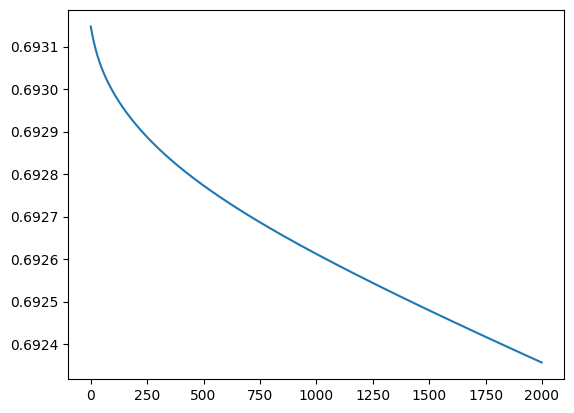

In [8]:
# plost cost_hist
plt.plot(models[0].cost_hist)